https://github.com/YeYuanFrancis

The goal of this project is to create an AI-based sommelier that predicts a wine’s quality based on its physicochemical characteristics. Rather than relying on highly trained human sommeliers, the approach leverages physicochemical data and machine learning models to predict quality scores. The models are trained using past wine quality reviews provided by human sommeliers. This solution could potentially reduce the costs and subjectivity associated with human tasters. In this report, we explore the use of RandomForestRegressor and other techniques to predict wine quality and evaluate their performance.

In [8]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import joblib

In [9]:
# load data
wine_train = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-train.csv",
)
wine_test = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-test.csv",
)
wine_train.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
2,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red


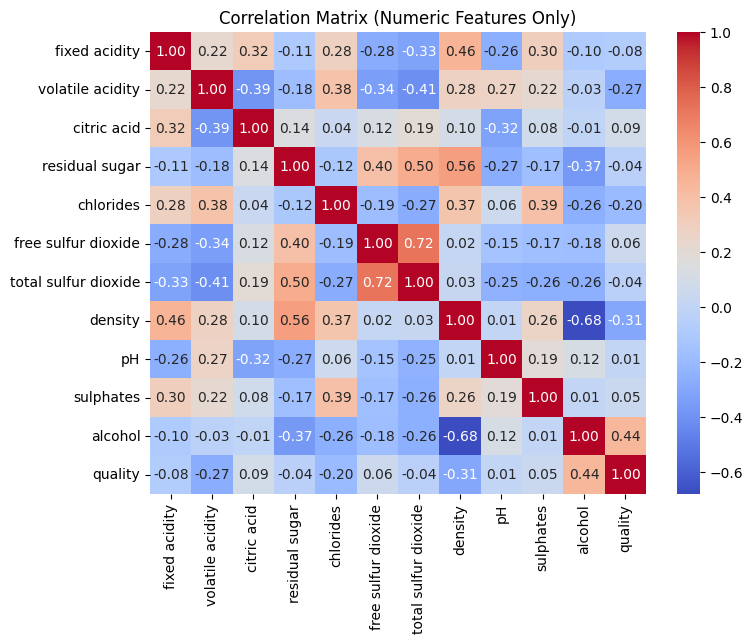

In [10]:
# Visualization
# Correlation heatmap for numeric features only
plt.figure(figsize=(8,6))
corr = wine_train.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Features Only)')
plt.show()

In [11]:
# process data for ML
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessing pipelines
numerical_pipeline = Pipeline(
    steps=[
        ("MedianImputer", SimpleImputer(strategy="median")),
        ("Standardize", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Model Selection and Training
# Define the model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100],         # Reduced from [100, 200]
    'regressor__max_depth': [20, 25, 30],         # Limited depth
    'regressor__min_samples_split': [2],  # Increased split
}


In [12]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

# train models
grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest Parameters:", grid_search.best_params_)

# Define a function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred_test = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    return mae

test_mae = evaluate_model(grid_search, X_test, y_test)
print(f"\nTest MAE: {test_mae:.2f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best Parameters: {'regressor__max_depth': 25, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}

Test MAE: 0.48
